[View in Colaboratory](https://colab.research.google.com/github/aunz/ds/blob/master/Customer_segmentation.ipynb)

# Customer segmentation

Date from UCI: https://archive.ics.uci.edu/ml/datasets/Online+Retail




In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Fetch the data, this can take up to ~ 2 minutes

In [2]:
%%time
!pip install xlrd # for reading excel
data = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

CPU times: user 42.9 s, sys: 377 ms, total: 43.3 s
Wall time: 48.2 s


In the data, there are:
- 8 features: InvoiceNo, StockCode, Description, Quanity, InvoiceDate, UnitPrice, CustomerID, Country
- 541909 records
- 25900 Invoice
- 4372 customer with ID. 135080 records have no customerID 
- 4070 StockCode but 4223 Description, so some StockCodes must have 1 more than descriptions
- 38 countries
- Transfactions started from 201-12-01 till 2101-12-09 (based on InvoiceDate)


The data use ~ 33 MB of memory

In [9]:
print('Shape', data.shape)
print('\n\nDate info:', data.info())
print('\n\nnunique', data.nunique())
print('\nTransaction date', data.InvoiceDate.min(), data.InvoiceDate.max())
data.groupby(['StockCode', 'Description']).size().reset_index() # to show that some stockCode are associated with more than 1 description 

data.head()

Shape (541909, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
isCancelled    541909 non-null bool
TotalSpent     541909 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 37.7+ MB


Date info: None


nunique InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
isCancelled        2
TotalSpent      6204
dtype: int64

Transaction date 2010-12-01 08:26:00 2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelled,TotalSpent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34


### InvoiceNo
- 25900 invoices (9288 are cancellation)
- Most invoices have only 1 type of product
- The median is 10 types of products per invoice
- The mean is 21 types of products
- The maximum number of products is 1114 types of product in a single invoice!!!
- This InvoiceNo is 573585:
    - has 5198 items
    - total: \$16875 (wonder if they got discount)
    - on 2010-10-31 14:41
    - in UK
    - unfortunately, no customerID
    - (It must has been quite challenging, thinking about the logistics to get these products together, shipping, etc..)

count    25900.000000
mean        20.923127
std         43.031334
min          1.000000
25%          2.000000
50%         10.000000
75%         23.000000
max       1114.000000
Name: InvoiceNo, dtype: float64
0 5841 1612 1095 815 788 670 652 631 629 553 573 496 519 521 548 569 454 434 481 438 408 344 356 321
Not cancelled vs cancelled invoice:
 False    532621
True       9288
Name: isCancelled, dtype: int64
Total spent: 16874.579999999998


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,isCancelled,TotalSpent
430237,573585,11001,ASSTD DESIGN RACING CAR PEN,2,2011-10-31 14:41:00,3.29,NaN,United Kingdom,False,6.58
430238,573585,15036,ASSORTED COLOURS SILK FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom,False,24.45
430239,573585,15039,SANDALWOOD FAN,15,2011-10-31 14:41:00,1.63,NaN,United Kingdom,False,24.45
430240,573585,15056BL,EDWARDIAN PARASOL BLACK,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom,False,12.46
430241,573585,15056N,EDWARDIAN PARASOL NATURAL,1,2011-10-31 14:41:00,12.46,NaN,United Kingdom,False,12.46


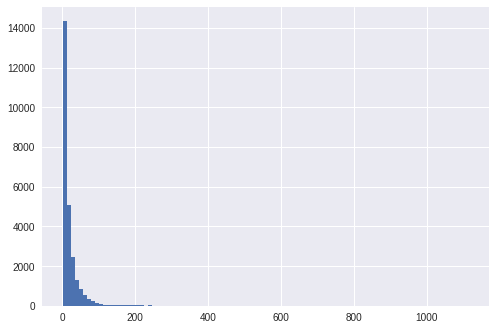

In [4]:
# invoice begin with C is cancelled, create a feature/variable called isCancelled (for the lack of a better term)
data['isCancelled'] = data['InvoiceNo'].astype(str).str.startswith('C')

# create another feature/variable called total spent
data['TotalSpent'] = data[['Quantity', 'UnitPrice']].prod(1)

tmp = data['InvoiceNo'].value_counts()
print(tmp.describe())
plt.hist(tmp, 100);
print(*np.bincount(tmp)[:25])


print('Not cancelled vs cancelled invoice:\n', data['isCancelled'].value_counts())

# the biggest invoice
tmp = tmp.sort_values(ascending=False).index[0]
print('Total spent:', data[data['InvoiceNo'] == tmp]['TotalSpent'].sum())
data[data['InvoiceNo'] == tmp].head()

### InvoiceDate
- The dataset cover a period just a little bit over 1 year
- On average, there are ~1449 invoices per day (mean)
- The median is 1427 invoices per day
- They close on Sunday, Xmas, somehere around Easter
- Towards the end of 2011 (from Nov), the number of invoices per day increased steadly, it's Xmas time!

count     374.000000
mean     1448.954545
std      1018.604579
min         0.000000
25%       875.250000
50%      1427.000000
75%      1944.500000
max      5331.000000
dtype: float64


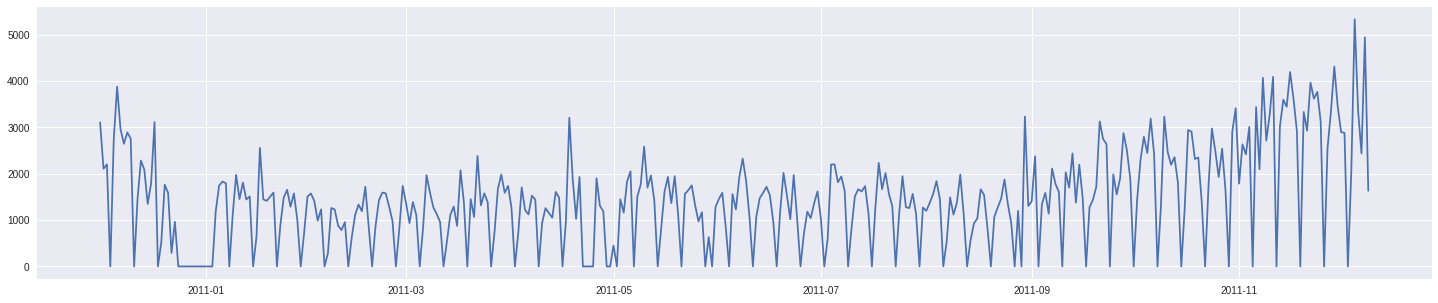

In [5]:
tmp = data.resample('D', on='InvoiceDate').size() # including cancellation
print(tmp.describe())
plt.figure(figsize=(25, 5))
plt.plot(tmp, '-');

### Country
- 38 of them
- But the majority of the transaction and values came from UK

,size,mean,sum
Country,,,
United Kingdom,495478,16.525065,8.187806e+06
Germany,9495,23.348943,2.216982e+05
France,8557,23.069288,1.974039e+05
EIRE,8196,32.122599,2.632768e+05
Spain,2533,21.624390,5.477458e+04


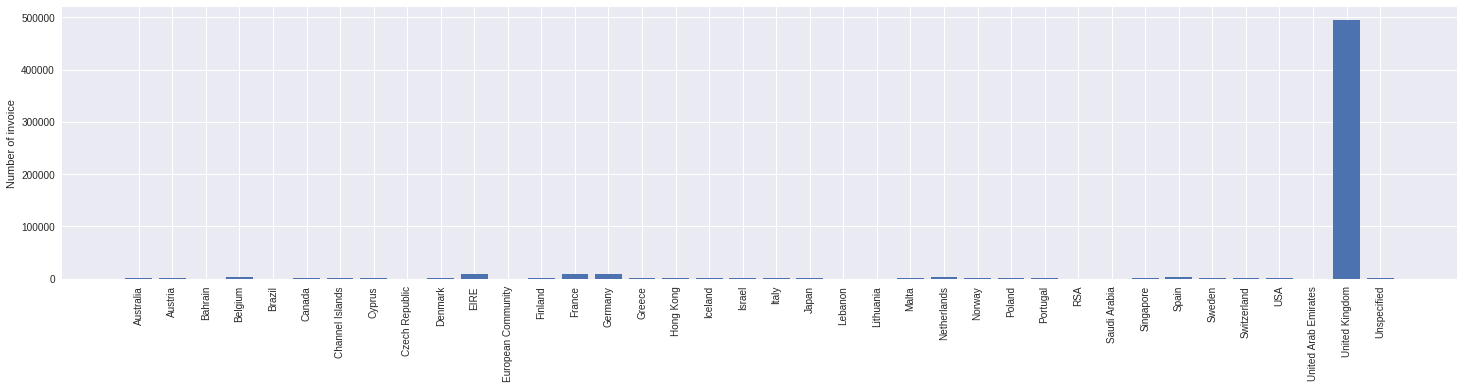

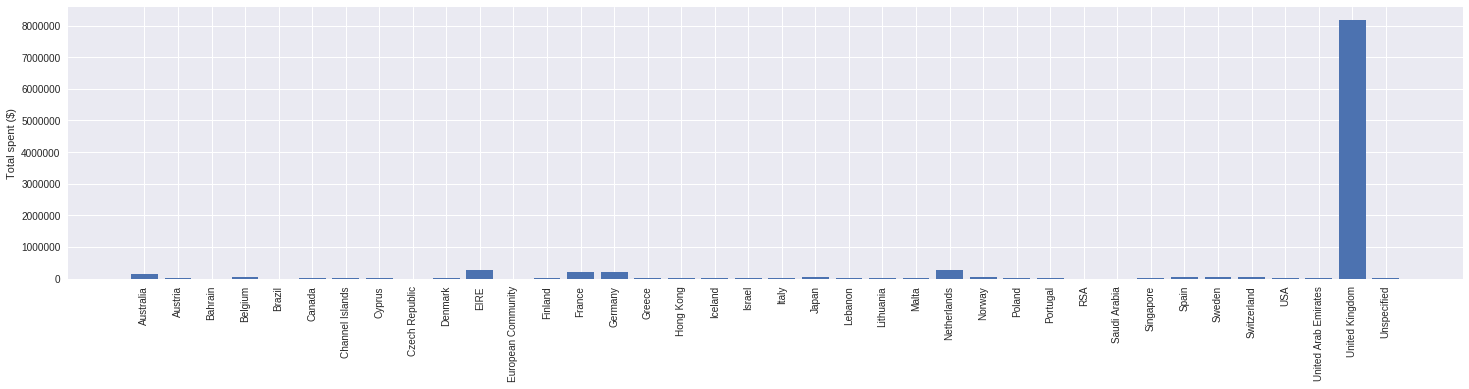

In [6]:
tmp = data.groupby('Country')['TotalSpent'].agg(['size', 'mean', 'sum']).sort_values('size', ascending=False)
plt.figure(figsize=(25, 5))
plt.bar(tmp.index, tmp['size'])
plt.ylabel('Number of invoice')
plt.xticks(tmp.index, tmp.index, rotation='vertical')

plt.figure(figsize=(25, 5))
plt.bar(tmp.index, tmp['sum'])
plt.ylabel('Total spent ($)')
plt.xticks(tmp.index, tmp.index, rotation='vertical');

tmp.head()

We are going to reduce the size of the dataset
- Remove records with no customerID
- Only retain records in UK (because some researches indicate that customer clusters vary by geography)
- The reduced dataset now has 361878 records, from the original of 541909 (~1/3th reduction)

In [7]:
data2 = data[(data['CustomerID'].notnull()) & (data['Country'] == 'United Kingdom')].drop(columns=['Country'])
print('New shape', data2.shape)

# assign new features

data2.head()

New shape (361878, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,isCancelled,TotalSpent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,False,20.34


In [0]:
# data['isCancelled'] & data['Quantity'] < 0
# pd.concat([data['isCancelled'], data['Quantity'] < 0], 1).groupby(['isCancelled', 'Quantity']).size()
# tmp = pd.concat([data['isCancelled'], data['Quantity'] < 0], 1)
# data.iloc[np.where((~data['isCancelled']) & (data['Quantity'] < 0))]
# data.iloc[np.where((data['isCancelled']) & (data['Quantity'] > 0))]

# data['isCancelled'].value_counts()